# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [81]:
!wget https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/students.csv
!wget https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/diabetes.csv

--2024-05-17 17:34:18--  https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/students.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7794 (7.6K) [text/plain]
Saving to: ‘students.csv.1’

students.csv.1      100%[===================>]   7.61K  --.-KB/s    in 0s      

2024-05-17 17:34:18 (79.6 MB/s) - ‘students.csv.1’ saved [7794/7794]

--2024-05-17 17:34:18--  https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [82]:
overall = 10
k1 = 8
k2 = 2

p_k1 = k1/overall
p_k2 = k2/overall

impurity = -(p_k1*np.log(p_k1) + p_k2*np.log(p_k2))
round(impurity, 2)

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [83]:
left_k1, left_k2 = 8, 0

right_k1, right_k2 = 0, 2

# левый лист
left_total = left_k1 + left_k2
left_gini = 1 - (left_k1 / left_total) ** 2 - (left_k2 / left_total) ** 2

# правый лист
right_total = right_k1 + right_k2
right_gini = 1 - (right_k1 / right_total) ** 2 - (right_k2 / right_total) ** 2

# импьюрити в узле
impurity = 1 - (p_k1 ** 2) - (p_k2 ** 2)
# то наскок у нас хорошо разбиение
Q = impurity - (left_total / overall) * left_gini - (right_total / overall) * right_gini
round(Q, 2)

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [84]:
# просто нужно посчитать среднее
objects = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
np.mean(objects)

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [85]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [86]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.Series],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """

    if len(np.unique(feature_vector)) == 1:
        return None, None, None, float("inf")

    if feature_type == "categorical":
        # Идея из лекции по ссылке в задании, разделяем на 2 непересекающихся множества
        uniq_categories, inverse_indices = np.unique(feature_vector, return_inverse=True)

        if task == "classification":
            # считаем пропорцию объектов с меткой 1 для каждой категории
            category_proportion = np.array([np.mean(target_vector[inverse_indices == i] == 1) for i in range(len(uniq_categories))])
        else:
            # считаем среднее значение таргета для каждой категории
            category_proportion = np.array([np.mean(target_vector[inverse_indices == i]) for i in range(len(uniq_categories))])

        # сортируем категории по значению их пропорции или признака
        sorted_indices = np.argsort(category_proportion)
        sorted_categories = uniq_categories[sorted_indices]
        # сортируем фичу
        feature_vector = sorted_indices[inverse_indices]

    # получаем индексы отсортированного веткора фичей и сортируем по этим индексам фичи и таргет
    idx_sorted = np.argsort(feature_vector)
    feature_sorted = feature_vector[idx_sorted]
    target_sorted = target_vector[idx_sorted]

    # достаем уникальные пороги, причем они не должны быть слипшемися
    unique_thresholds = (feature_sorted[1:] + feature_sorted[:-1]) / 2
    unique_mask = feature_sorted[1:] != feature_sorted[:-1]
    thresholds = unique_thresholds[unique_mask]

    if task == "classification":
        num_classes = np.max(target_sorted) + 1
        # создается матрица 2 на 2 с диагональю из единичек, из этой матрицы выбираются строки по порядку target_sroted
        # далее складываются кумулятивные суммы по вертикали, а потом мы убираем последний элемент
        left_counts = np.cumsum(np.eye(num_classes)[target_sorted], axis=0)[:-1]
        # считаем количество 0 и 1 из target_sorted
        total_counts = np.bincount(target_sorted, minlength=num_classes)
        right_counts = total_counts - left_counts

        #создаем массив от 1 до длины target_sorted
        left_sizes = np.arange(1, len(target_sorted))
        right_sizes = len(target_sorted) - left_sizes

        # считаем джини, left_count и right_counts это матрицы, где строки это пороги, а столбцы классы
        # [:, None] добавляет новое измерение, чтобы можно было поделить,  потом берем суммы по строкам
        # вернется одномерный массив, где каждый элемент это сумма квадратов элементов в какой-то строке матрицы
        left_gini = 1 - np.sum((left_counts / left_sizes[:, None]) ** 2, axis=1)
        right_gini = 1 - np.sum((right_counts / right_sizes[:, None]) ** 2, axis=1)

        # считаем джини с коэффициентами для всех порогов, потом применяем маску
        total_gini = (left_gini * left_sizes + right_gini * right_sizes) / len(target_sorted)
        total_gini = total_gini[unique_mask]

        # ищем наименьший джини, его и возвращаем как лучший
        best_idx = np.argmin(total_gini)
        threshold_best = thresholds[best_idx]
        gini_best = total_gini[best_idx]

        if feature_type == "categorical":
            best_threshold_index = round(thresholds[best_idx] + 0.1)
            threshold_best = sorted_categories[:best_threshold_index]
        else:
            threshold_best = thresholds[best_idx]

        return thresholds, total_gini, threshold_best, gini_best

    elif task == "regression":
        # делаем cумму квадратов всех элементов из таргет сортед, собираем кум. суммы
        total_sum_y_squared = np.sum(target_sorted ** 2)
        cumsum_y = np.cumsum(target_sorted)
        # считаем кум суммы из квадратов таргет сортед
        cumsum_y_squared = np.cumsum(target_sorted ** 2)

        # отбрасываем последние элементы
        left_sum_y = cumsum_y[:-1]
        left_sum_y_squared = cumsum_y_squared[:-1]
        # массив от 1 до длины таргет сортед
        left_counts = np.arange(1, len(target_sorted))

        # берем только правую часть из кумсум, далее делаем то же самое, что и с левой частью
        right_sum_y = cumsum_y[-1] - left_sum_y
        right_sum_y_squared = total_sum_y_squared - left_sum_y_squared
        right_counts = len(target_sorted) - left_counts

        # содержит значение дисперсии для каждого возможного разбиения слева от порога
        left_var = (left_sum_y_squared - left_sum_y ** 2 / left_counts) / left_counts
        # значения дисперсии правее порога
        right_var = (right_sum_y_squared - right_sum_y ** 2 / right_counts) / right_counts
        # все возможные дисперии в зависимости от разбиения
        total_var = (left_var * left_counts + right_var * right_counts) / len(target_sorted)

        # применяем маску
        vars = total_var[unique_mask]

        # тут как в классификации
        min_error_idx = np.argmin(vars)
        threshold_best = thresholds[min_error_idx]
        var_best = vars[min_error_idx]

        if feature_type == "categorical":
            best_threshold_index = round(thresholds[min_error_idx] + 0.1)
            threshold_best = sorted_categories[:best_threshold_index]

        elif feature_type == "real":
            threshold_best = thresholds[min_error_idx]

        return thresholds, vars, threshold_best, var_best

    return None, None, None, None

Эту функцию можно протестировать на датасете `California`.

In [87]:
from sklearn.datasets import fetch_california_housing

In [88]:
import warnings
warnings.filterwarnings("ignore")
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [89]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [90]:
thresholds, impurity, threshold_best, gini_best = find_best_split(X['MedInc'].values, y, task='regression')

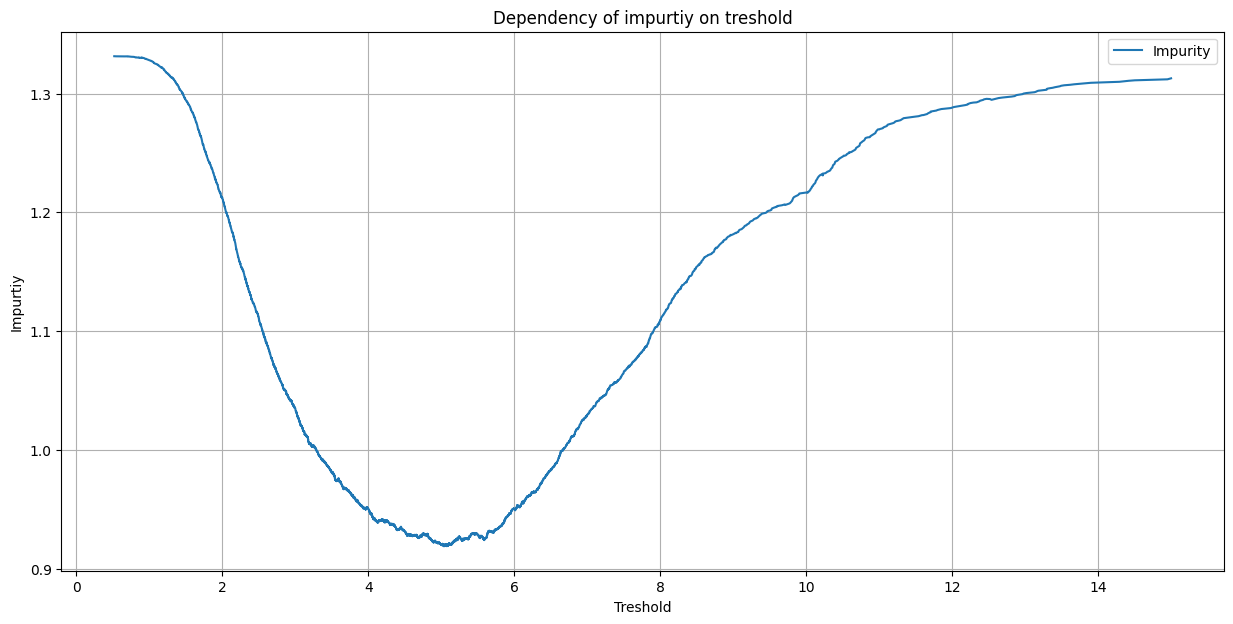

In [91]:
plt.figure(figsize=(15,7))
plt.plot(thresholds, impurity, label="Impurity")
plt.title("Dependency of impurtiy on treshold")
plt.xlabel('Treshold')
plt.ylabel('Impurtiy')
plt.grid(True)
plt.legend()
plt.show()


Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [92]:

predicats = {}
for feature in X.columns:
  thresholds, impurity, threshold_best, impurity_best = find_best_split(X[str(feature)].values, y, task='regression')
  predicats[feature] = [threshold_best, impurity_best]


In [93]:
predicats

{'MedInc': [5.03515, 0.9187989138794026],
 'HouseAge': [51.5, 1.3006493594832342],
 'AveRooms': [6.374305146225346, 1.1723423474919985],
 'AveBedrms': [1.1033776245480702, 1.3162968844857],
 'Population': [1160.5, 1.3287196520337612],
 'AveOccup': [3.1125433206272035, 1.2576315943038103],
 'Latitude': [37.935, 1.2412162124280208],
 'Longitude': [-121.86500000000001, 1.281339248048714]}

Лучший принак для разделения в первой вершине дерева это MedInc, трешхолд - 5.035, impurity - 0.918

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [94]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = None


    def _fit_node(self, sub_X: np.ndarray, sub_y: np.ndarray, node: dict, depth=0):
      if np.all(sub_y == sub_y[0]):
          node["type"] = "terminal"
          node["class"] = sub_y[0]
          return

      feature_best, threshold_best, gini_best, best_split = None, None, float('inf'), None

      # берем тип признака и его индекс
      for feature_index, feature_type in enumerate(self._feature_types):
          # берем вектор фичи
          feature_vector = sub_X[:, feature_index]

          if feature_type == "categorical":
              thresholds, total_gini, threshold, gini = find_best_split(feature_vector, sub_y, feature_type="categorical")
              if gini < gini_best and threshold is not None:
                  feature_best = feature_index
                  threshold_best = threshold
                  gini_best = gini
                  best_split = np.isin(sub_X[:, feature_index], list(threshold))


          else:
              thresholds, total_gini, threshold, gini = find_best_split(feature_vector, sub_y, feature_type="real")
              if gini < gini_best and threshold is not None :
                  feature_best = feature_index
                  threshold_best = threshold
                  gini_best = gini
                  best_split = sub_X[:, feature_index] <= threshold

      if feature_best is None:
          node["type"] = "terminal"
          node["class"] = Counter(sub_y).most_common(1)[0][0]
          return

      # если у нас определенная фича, то добавляем к ней важность
      self._feature_importances[feature_best] += self.calculate_importance(sub_X, sub_y, feature_best, best_split)

      node.update({
          "type": "nonterminal",
          "feature_split": feature_best,
          "threshold": threshold_best,
          "category_split": threshold_best if self._feature_types[feature_best] == "categorical" else None,
          "left_child": {},
          "right_child": {}
      })

      self._fit_node(sub_X[best_split], sub_y[best_split], node["left_child"], depth + 1)
      self._fit_node(sub_X[~best_split], sub_y[~best_split], node["right_child"], depth + 1)


    def _predict_node(self, x: np.ndarray, node: dict) -> int:
      """"""
      # заходим в цикл, если у нас узел не листовой
      while node['type'] != 'terminal':
          if self._feature_types[node["feature_split"]] == "real":
              # если у нас значение признака меньше порога, то мы его отправляем в левое поддерево, иначе в правое
              node = node["left_child"] if x[node["feature_split"]] <= node["threshold"] else node["right_child"]
          else:
              # подход с двумя непересекающимися подмножествами(из лекции), в них содержатся категории в отсортированном порядке
              # если наш признак в множестве, то мы его отправляем в левое поддерево, иначе в правое
              node = node["left_child"] if x[node["feature_split"]] in node["category_split"] else node["right_child"]
      return node['class']

    def fill_missing_data(self, X: np.ndarray) -> np.ndarray:
        # заполняем пустые данные самым частым значением
        X_filled = X.copy()

        for i, feature_type in enumerate(self._feature_types):
            if feature_type == "real":
                # заполянем средним
                mean_value = np.nanmean(X[:, i])
                X_filled[np.isnan(X_filled[:, i]), i] = mean_value
            elif feature_type == "categorical":
                # заполняем самым частым
                mode_value = self.mode(X[:, i])
                X_filled[X_filled[:, i] == None, i] = mode_value

        return X_filled

    @staticmethod
    def mode(array):
        # для категориальных считаем
        values, counts = np.unique(array[array != None], return_counts=True)
        if len(values) == 0:
            return None
        return values[np.argmax(counts)]


    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        X = self.fill_missing_data(X)
        self.len_y = len(y)
        # заполняем словарь фичей от 0 до  количества фичей - 1
        self._feature_importances = {i: 0 for i in range(X.shape[1])}
        self._fit_node(X, y, self._tree)


        # нормализуем наши важности признаков
        self._feature_importances = {key: np.round(value / sum(self._feature_importances.values()), 5) for key, value in self._feature_importances.items()}


    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)


    def calculate_node_impurity(self, y):
        # считаем импьюрити в узле
        if self.task == "classification":
            class_proba = np.bincount(y) / y.size
            node_impurity = 1 - np.sum(np.square(class_proba))

        elif self.task == "regression":
            node_impurity = np.sum(np.square(np.mean(y) - y)) / len(y)

        return node_impurity


    def calculate_importance(self, x, y, feature_id, best_split):
        y_left, y_right = y[best_split], y[~best_split]

        node_impurity = self.calculate_node_impurity(y)
        left_impurity = self.calculate_node_impurity(y_left)
        right_impurity = self.calculate_node_impurity(y_right)

        if self._feature_types[feature_id] == 'categorical':  # Если категориальный признак
            # я не понял, как в sklearn обрабатываются категориальные признаки
            impurity_decrease = (len(y) / self.len_y)*(node_impurity - (len(y_right)/len(y)*right_impurity - (len(y_left)/len(y))*left_impurity))
            total_impurity_decrease = impurity_decrease

        else:  # Если вещественный признак
            impurity_decrease = len(y)*node_impurity/self.len_y - (len(y_right)/self.len_y)*right_impurity - (len(y_left)/self.len_y)*left_impurity
            total_impurity_decrease = impurity_decrease

        return total_impurity_decrease


**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [95]:
df_st = pd.read_csv('students.csv')
df_st

,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,0.08,0.08,0.10,0.24,0.90,1
2,2,0.06,0.06,0.05,0.25,0.33,0
3,3,0.10,0.10,0.15,0.65,0.30,1
4,4,0.08,0.08,0.08,0.98,0.24,0
...,...,...,...,...,...,...,...
253,253,0.61,0.78,0.69,0.92,0.58,1
254,254,0.78,0.61,0.71,0.19,0.60,1
255,255,0.54,0.82,0.71,0.29,0.77,1
256,256,0.50,0.75,0.81,0.61,0.26,1


In [96]:
X_st = df_st.drop("Unnamed: 0", axis=1).drop("UNS", axis=1)
y_st = df_st["UNS"]

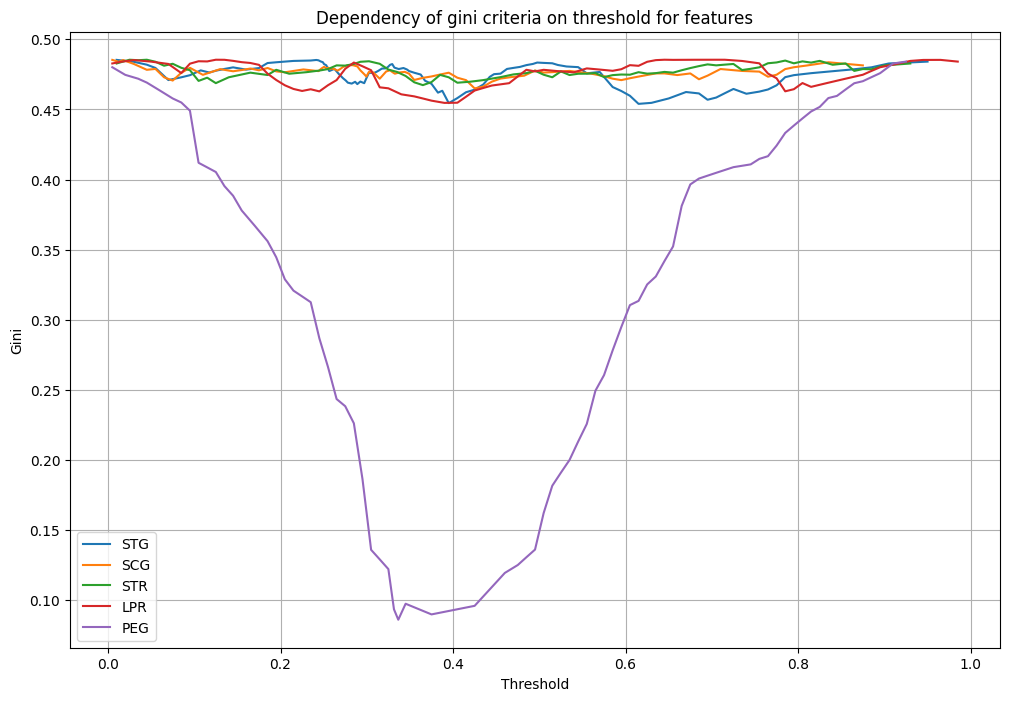

In [97]:
plt.figure(figsize=(12,8))
plt.title('Dependency of gini criteria on threshold for features')
for feature in df_st.columns[1:6]:
  thresholds, impurity, threshold_best, impurity_best = find_best_split(df_st[str(feature)].values, df_st["UNS"], task='classification')
  plt.plot(thresholds, impurity, label=f'{feature}')

plt.xlabel('Threshold')
plt.ylabel('Gini')
plt.grid(True)
plt.legend()
plt.show()


Теперь изобразим диаграммы рассеяния

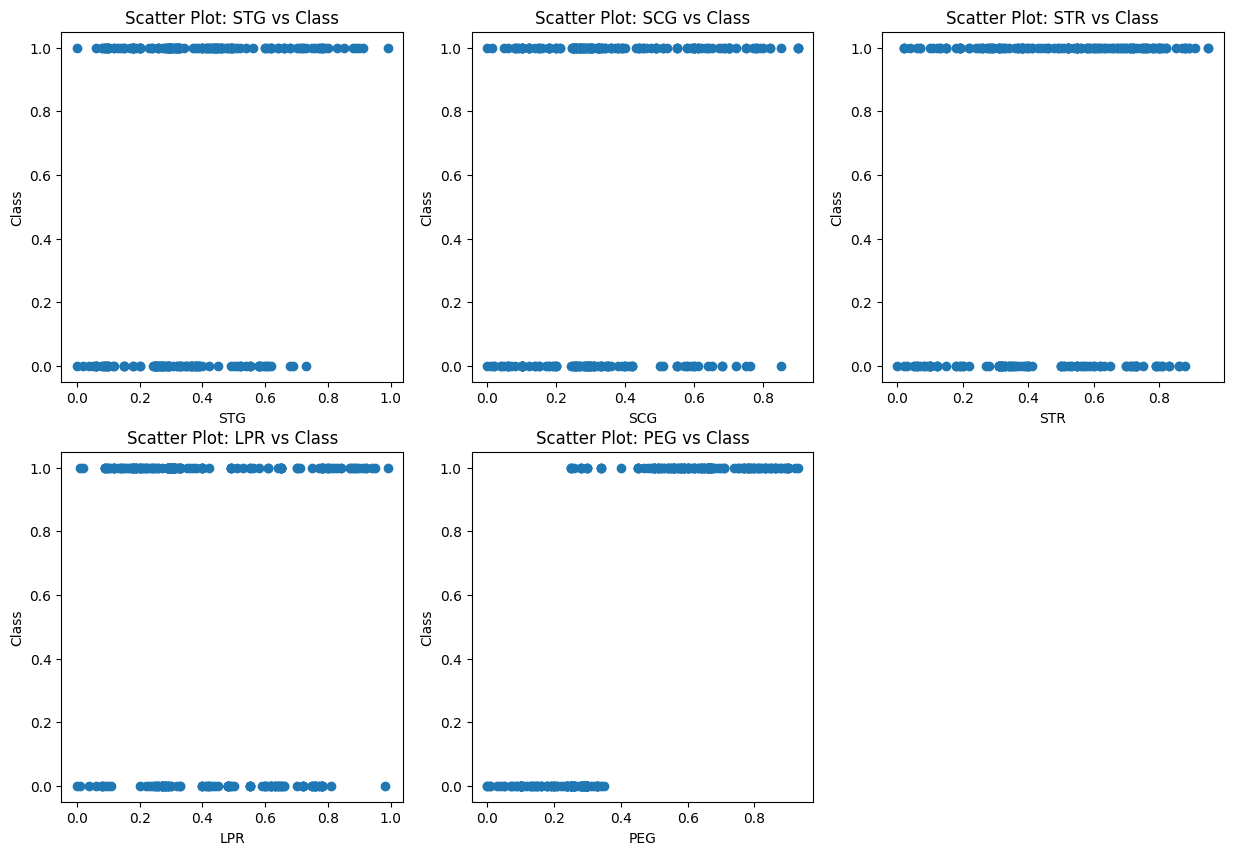

In [98]:
plt.figure(figsize=(15,10))
for i, feature in enumerate(df_st.columns[1:6]):
  plt.subplot(2, 3, i+1)
  plt.scatter(x=df_st[feature], y=df_st["UNS"], label=f'{feature}')
  plt.title(f'Scatter Plot: {feature} vs target')
  plt.xlabel(feature)
  plt.ylabel('Class')

plt.show()


Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Ответ: Лучше всего производить деление по PEG, так как критерий джини достигает минимума на этом признаке, то есть лучше всего делит выборку. Это согласуется с диаграммой рассеивания, видно, что PEG и CLASS можно легко разделить по порогу примерно 0.37. У остальных фичей, очень большое пересчение 0 и 1 класса вне зависимости от порога.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [99]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data

--2024-05-17 17:34:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘agaricus-lepiota.data.1’

agaricus-lepiota.da     [           <=>      ] 364.95K   116KB/s    in 3.2s    

2024-05-17 17:34:25 (115 KB/s) - ‘agaricus-lepiota.data.1’ saved [373704]



In [100]:
df = pd.read_csv("agaricus-lepiota.data", header=None)
df.head(6)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [101]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [102]:
# Применяем лэйбл энкодер к каждому столбцу из df, учимся сразу на всей выборке
label = LabelEncoder()
df = df.apply(label.fit_transform)
df

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,3,2,4,0,5,0,0,0,11,...,2,5,5,0,1,1,4,0,1,2
8120,0,5,2,4,0,5,0,0,0,11,...,2,5,5,0,0,1,4,0,4,2
8121,0,2,2,4,0,5,0,0,0,5,...,2,5,5,0,1,1,4,0,1,2
8122,1,3,3,4,0,8,1,0,1,0,...,1,7,7,0,2,1,0,7,4,2


In [103]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(0, axis=1).to_numpy(), df[0].to_numpy(), test_size=0.5, random_state=52)

In [104]:
from sklearn.metrics import accuracy_score
tree = DecisionTree(feature_types=['categorical'] * X_train.shape[1])
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

Получилось очень круто, для обработки категориальных признаков я использую подход с разделением на 2 непересекающихся подмножества, это описано в конспекте лекции по ссылке в задании 2.1.

### Расчет важности признаков

У меня получилось посчитать для вещественных фичей, но не для ктаегориальных.

Теперь посчитает важность признаков, как их считать я нашел по ссылке (https://stackoverflow.com/questions/49170296/scikit-learn-feature-importance-calculation-in-decision-trees)


Сначала считаем категориальные

In [105]:
tree._feature_importances

{0: 0.00173,
 1: 0.0,
 2: 0.00064,
 3: 0.0,
 4: 0.91328,
 5: 0.0,
 6: 0.0,
 7: 0.00125,
 8: 0.02774,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.00355,
 13: 0.0,
 14: 0.03609,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.01573,
 20: 0.0,
 21: 0.0}

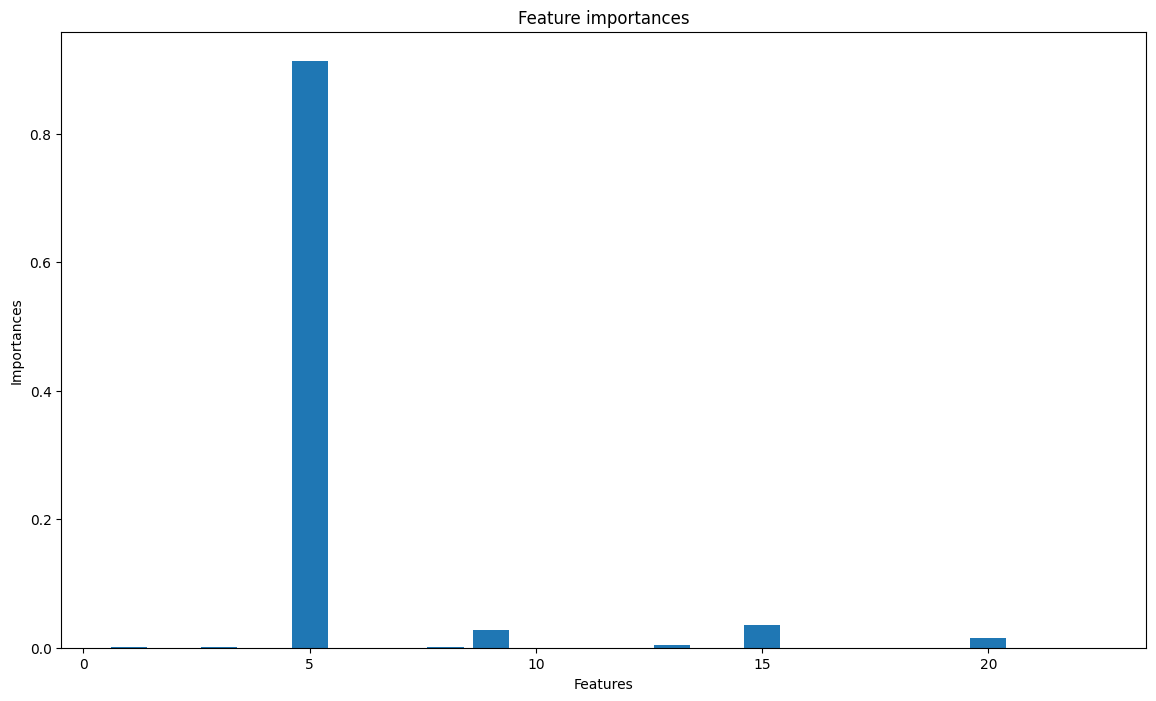

In [106]:
plt.figure(figsize=(14, 8))
plt.title("Feature importances")
plt.bar(df.drop(0, axis=1).columns, tree._feature_importances.values())
plt.xlabel("Features")
plt.ylabel("Importances")
plt.show()

Теперь посмотрим на дерево из sklearn

In [107]:
from sklearn.tree import DecisionTreeClassifier

t = DecisionTreeClassifier()
t.fit(X_train, y_train)
y_t = t.predict(X_test)
accuracy_score(y_test, y_t)

1.0

In [108]:
t.feature_importances_

array([0.        , 0.        , 0.00313178, 0.02948204, 0.        ,
       0.        , 0.        , 0.11718068, 0.35649407, 0.02197462,
       0.04838388, 0.        , 0.00135225, 0.        , 0.00454203,
       0.        , 0.        , 0.01547651, 0.        , 0.19239353,
       0.18084427, 0.02874434])

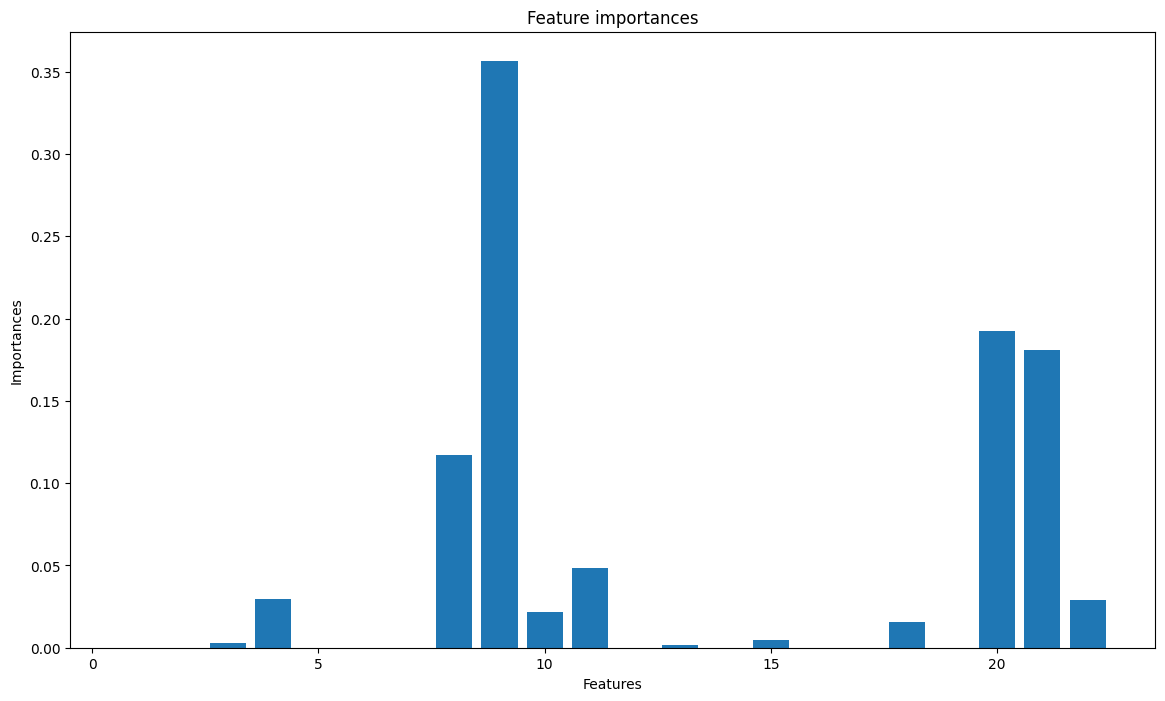

In [109]:
plt.figure(figsize=(14, 8))
plt.title("Feature importances")
plt.bar(df.drop(0, axis=1).columns, t.feature_importances_)
plt.xlabel("Features")
plt.ylabel("Importances")
plt.show()

Получился сильный перекос, так и не нашел как это фиксить.

Далее посчитаем для вещественных признаков

In [110]:
df_diab = pd.read_csv('diabetes.csv')
X = df_diab.drop('Outcome', axis=1).to_numpy()
y = df_diab['Outcome'].to_numpy()

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)

In [112]:
feature_types = ['real'] * X_train.shape[1]
tree = DecisionTree(feature_types=feature_types)
tree.fit(X_train, y_train)
accuracy_score(y_test, tree.predict(X_test))

0.7086614173228346

In [113]:
tree._feature_importances

{0: 0.08515,
 1: 0.35033,
 2: 0.07051,
 3: 0.05145,
 4: 0.03165,
 5: 0.20144,
 6: 0.08932,
 7: 0.12015}

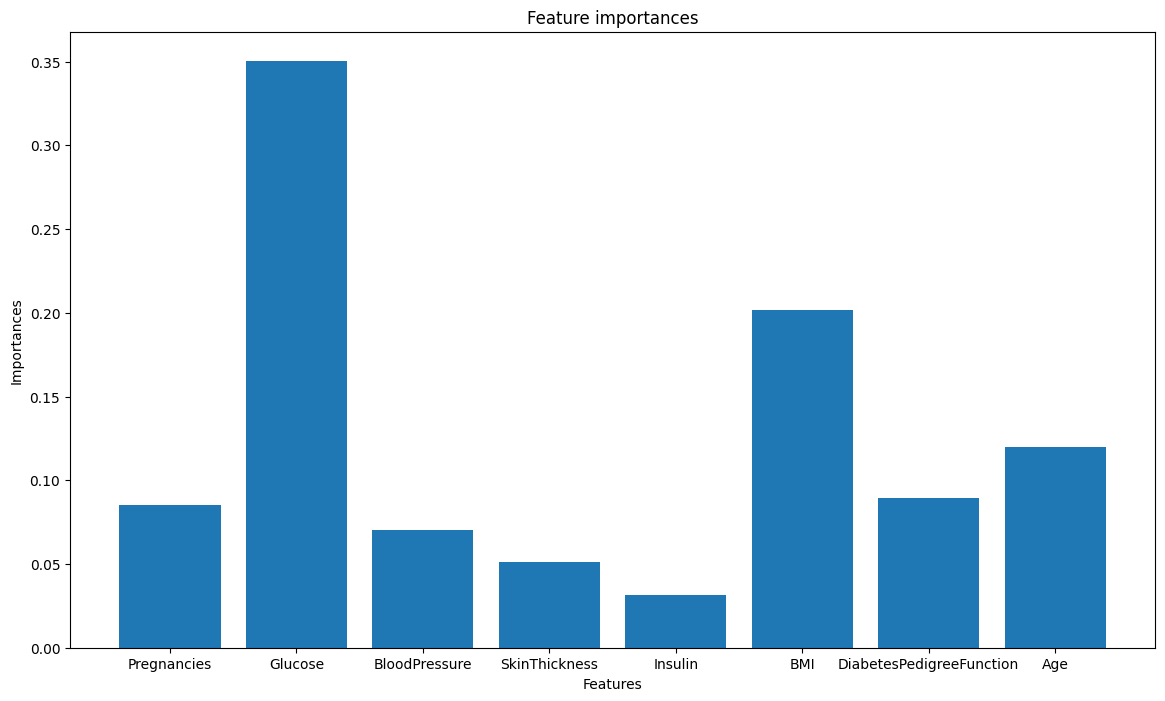

In [114]:
plt.figure(figsize=(14, 8))
plt.title("Feature importances")
plt.bar(df_diab.drop('Outcome', axis=1).columns, tree._feature_importances.values())
plt.xlabel("Features")
plt.ylabel("Importances")
plt.show()

In [115]:
tree = DecisionTreeClassifier(random_state=52)
tree.fit(X_train, y_train)
accuracy_score(y_test, tree.predict(X_test))

0.7125984251968503

In [116]:
tree.feature_importances_

array([0.04632048, 0.33878893, 0.07923512, 0.05102543, 0.04285265,
       0.20858288, 0.09404363, 0.13915088])

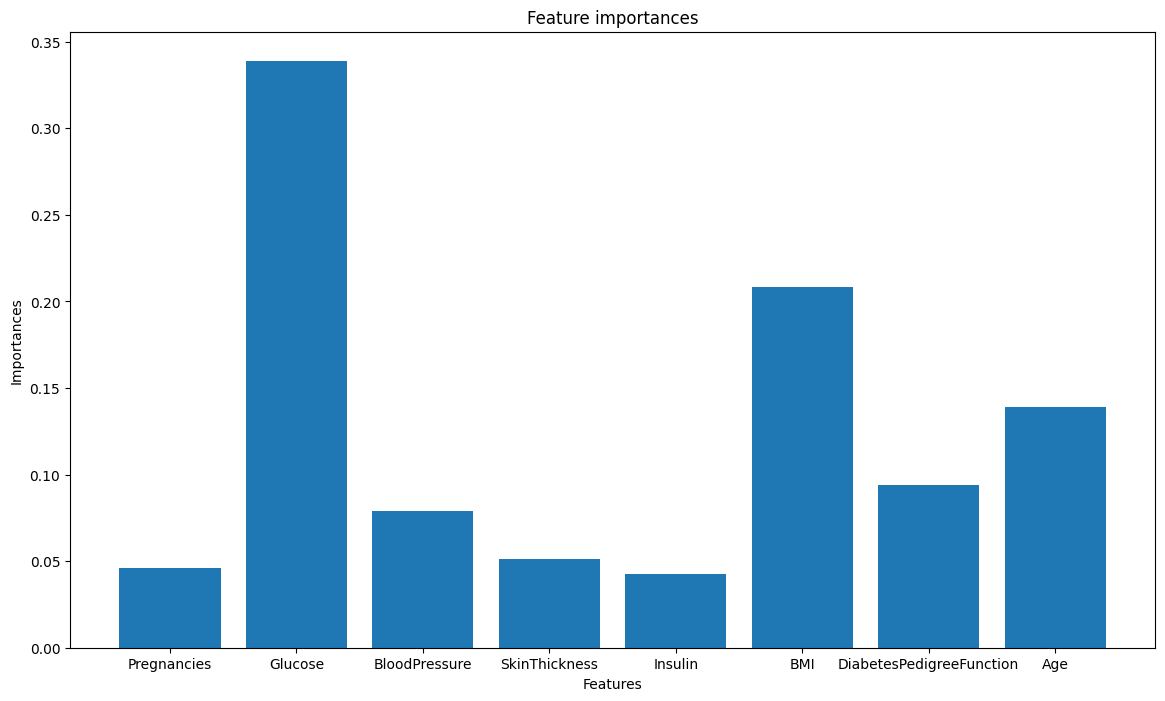

In [117]:
plt.figure(figsize=(14, 8))
plt.title("Feature importances")
plt.bar(df_diab.drop('Outcome', axis=1).columns, tree.feature_importances_)
plt.xlabel("Features")
plt.ylabel("Importances")
plt.show()

Здесь получилось все так же как у sklearn

### Заполнение пустых значений

В лекции по ссылке из 2.1 предлагают разные способы, я решил не реализовывать самый сложный(я устал делать обработку категориальных), взял методы попроще, так как там сказано, что это часто работают хорошо.

я не проверял робоспособность, но по идее все должно хорошо работать..

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [118]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier

In [119]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [120]:
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Посмотрим на распределение целевой переменной

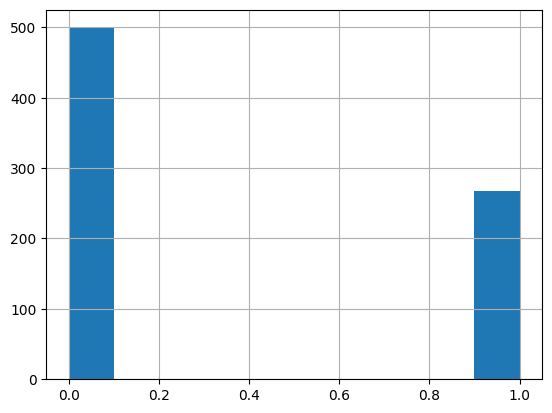

In [121]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [122]:
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

In [123]:
# Делаем тест и трейн
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52)
# Делим трейн на валидацию и трейн
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=52)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [124]:
# Используем optuna, фреймворк для эффективного поиска лучших гиперпараметров, нам его показывали на семинаре.
!pip install optuna

In [125]:
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score

In [126]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)

    model.fit(X_train_train, y_train_train)

    preds = model.predict(X_train_val)
    f1 = f1_score(y_train_val, preds)

    return f1

# максимизируем значение нашей функции, будет 50 попыток выбить самые лучшие параметры
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print('Лучшие гиперпараметры:', best_params)


[I 2024-05-17 17:34:35,606] A new study created in memory with name: no-name-5a24c667-68bd-40df-8bc7-f1a7e4764953
[I 2024-05-17 17:34:35,628] Trial 0 finished with value: 0.65625 and parameters: {'max_depth': 19, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.65625.
[I 2024-05-17 17:34:35,644] Trial 1 finished with value: 0.656 and parameters: {'max_depth': 11, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.65625.
[I 2024-05-17 17:34:35,655] Trial 2 finished with value: 0.6299212598425197 and parameters: {'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.65625.
[I 2024-05-17 17:34:35,665] Trial 3 finished with value: 0.732394366197183 and parameters: {'max_depth': 4, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.732394366197183.
[I 2024-05-17 17:34:35,676] Trial 4 finished with value: 0.6885245901639344 and parameters: {'max_depth': 12, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.732394366197183.
[I 2024-05-17 17:34:35,686] Trial 5 

Лучшие гиперпараметры: {'max_depth': 4, 'min_samples_leaf': 6}


In [127]:
# учим модель с параметрами, полученными с помощью  optuna
final_model = DecisionTreeClassifier(**best_params)
final_model.fit(X_train, y_train)

test_preds = final_model.predict(X_test)
accuracy = accuracy_score(y_test, test_preds)
precision = precision_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)

roc_auc = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, ROC-AUC: {roc_auc}')

Accuracy: 0.7316017316017316, Precision: 0.5686274509803921, Recall: 0.7631578947368421, ROC-AUC: 0.8008913412563667


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [128]:
tree = DecisionTreeClassifier()
cls_tress = BaggingClassifier(estimator=tree, n_estimators=50, random_state=52)

cls_tress.fit(X_train, y_train)

y_pred = cls_tress.predict(X_test)

print(f'accuracy: {accuracy_score(y_test, y_pred)}')
print(f'precision: {precision_score(y_test, y_pred)}')
print(f'recall: {recall_score(y_test, y_pred)}')
print(f'ROC-AUC: {roc_auc_score(y_test, cls_tress.predict_proba(X_test)[:, 1])}')

accuracy: 0.7705627705627706
precision: 0.6666666666666666
recall: 0.6052631578947368
ROC-AUC: 0.8169779286926995


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [129]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    model = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_split=min_samples_split, random_state=52)

    # кросс валидация
    f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()

    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # количество прогонов для поиска

# выврдим лучшие параметры
best_params = study.best_params
print('Лучшие гиперпараметры:', best_params)

[I 2024-05-17 17:34:37,143] A new study created in memory with name: no-name-7aa17a27-9f67-4027-8bbf-3b0ddf6fdfbd
[I 2024-05-17 17:34:37,964] Trial 0 finished with value: 0.6417269437055773 and parameters: {'max_depth': 24, 'min_samples_split': 9}. Best is trial 0 with value: 0.6417269437055773.
[I 2024-05-17 17:34:38,624] Trial 1 finished with value: 0.6320192080948399 and parameters: {'max_depth': 20, 'min_samples_split': 7}. Best is trial 0 with value: 0.6417269437055773.
[I 2024-05-17 17:34:39,328] Trial 2 finished with value: 0.6391570047823083 and parameters: {'max_depth': 11, 'min_samples_split': 9}. Best is trial 0 with value: 0.6417269437055773.
[I 2024-05-17 17:34:39,863] Trial 3 finished with value: 0.6417269437055773 and parameters: {'max_depth': 21, 'min_samples_split': 9}. Best is trial 0 with value: 0.6417269437055773.
[I 2024-05-17 17:34:40,657] Trial 4 finished with value: 0.6238976882577617 and parameters: {'max_depth': 29, 'min_samples_split': 8}. Best is trial 0 wit

Лучшие гиперпараметры: {'max_depth': 24, 'min_samples_split': 9}


In [130]:
final_model = RandomForestClassifier(**best_params, n_estimators=50, random_state=52)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, Roc_auc: {roc_auc}')

Accuracy: 0.7532467532467533, Precision: 0.6338028169014085, Recall: 0.5921052631578947, Roc_auc: 0.8191850594227504


Ответ: Бэггинг и случайный лес примерно одинаковые, при этом они лучше, чем обычное дерево, если сравнивать по auc roc.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

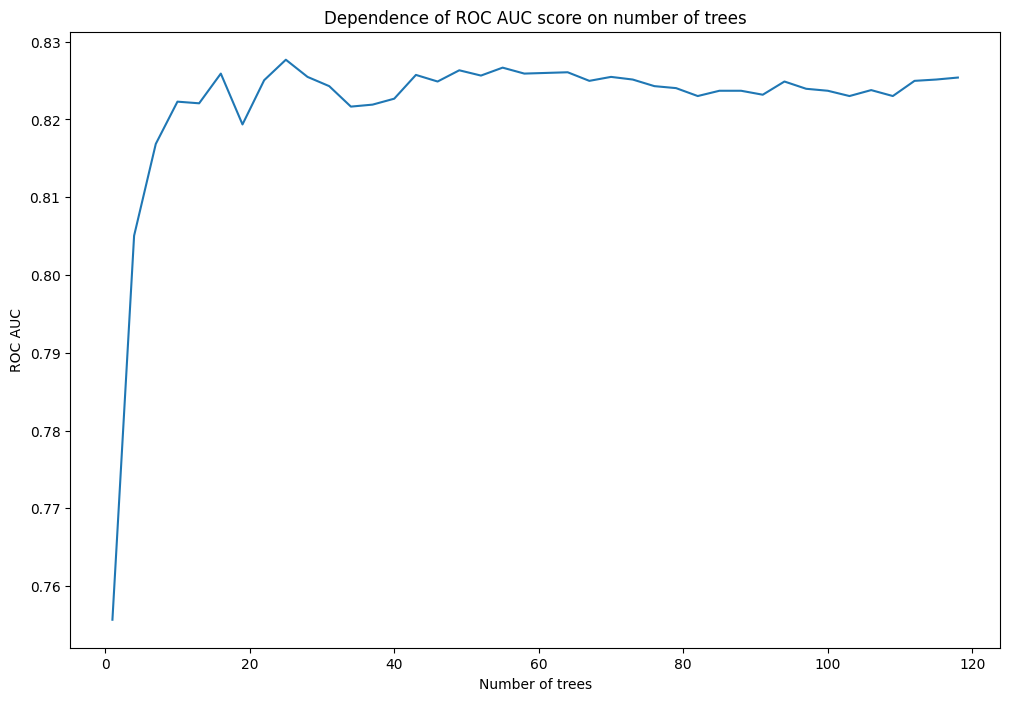

In [131]:
roc_auc = []

for number_trees in range(1, 120, 3):
    model = RandomForestClassifier(n_estimators=number_trees, max_depth=26, min_samples_leaf=9, random_state=52)
    model.fit(X_train, y_train)
    roc_auc.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

plt.figure(figsize=(12, 8))
plt.title("Dependence of ROC AUC score on number of trees")
plt.xlabel(r"Number of trees")
plt.ylabel(r"ROC AUC")
plt.plot(range(1, 120, 3), roc_auc)
plt.show()

Ответ: Примерно на 30 дереве метрика не меняется, это происходит из-за того, что модель не переобучается от количества деревьев.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

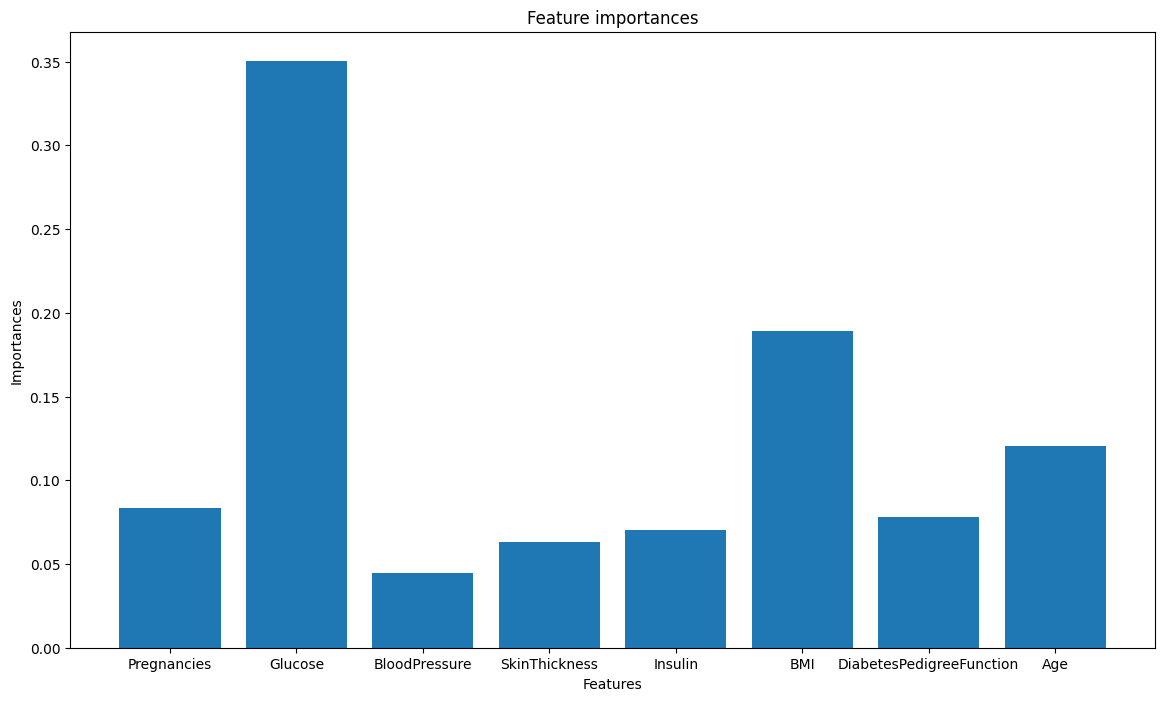

In [132]:
model = RandomForestClassifier(n_estimators=30, max_depth=26, min_samples_leaf=9, random_state=52)
model.fit(X_train, y_train)

plt.figure(figsize=(14, 8))
plt.title("Feature importances")
plt.bar(X_train.columns, model.feature_importances_)
plt.xlabel("Features")
plt.ylabel("Importances")
plt.show()

Ответ: Самый важный признак для определения диабета - количество глюкозы в крови, то есть сахара.

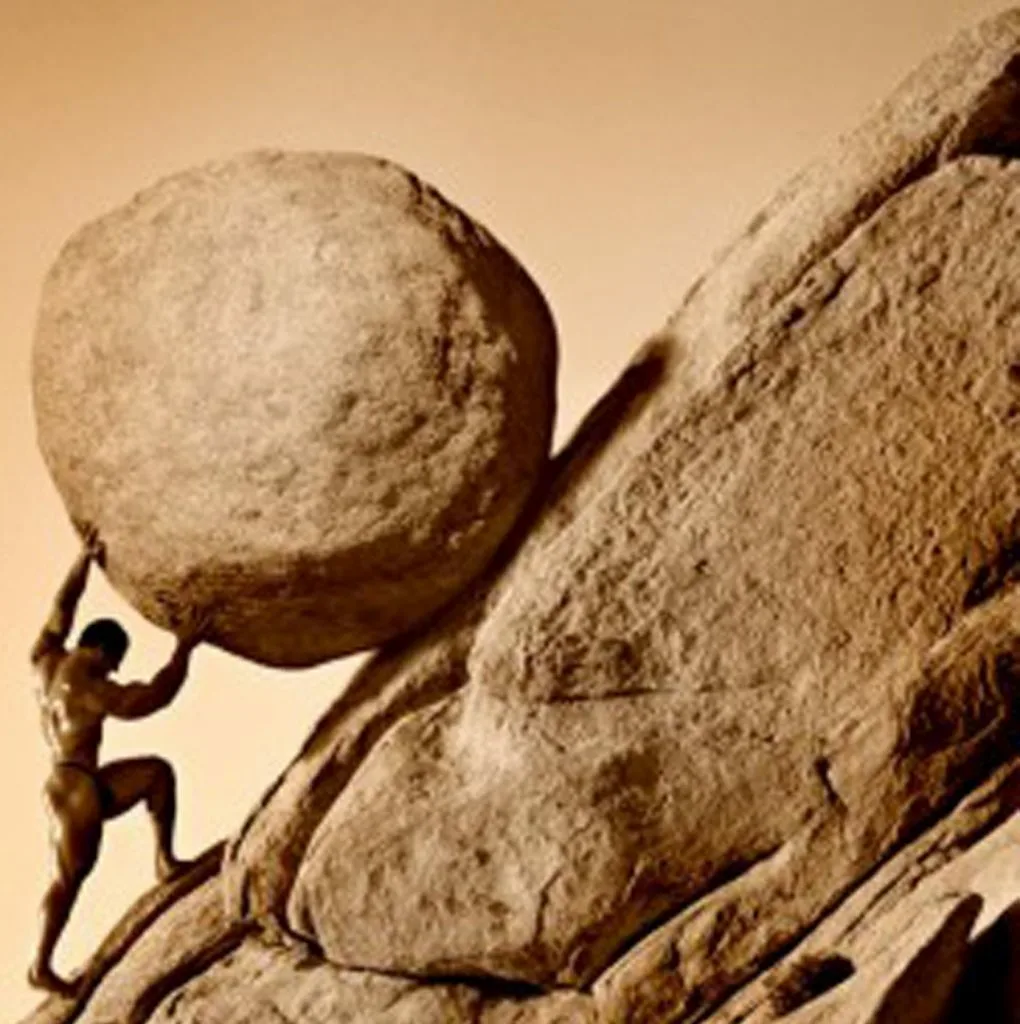